# V. MORO - Directed search

In [1]:
# Basic packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import functools

# Basic EMA Workbench packages
from ema_workbench import (Model, MultiprocessingEvaluator, Policy, Scenario, ScalarOutcome)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging

# Optimization EMA Workbench packages
from ema_workbench.em_framework.evaluators import BaseEvaluator
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.analysis import parcoords

ema_logging.log_to_stderr(ema_logging.INFO)
BaseEvaluator.reporting_frequency = 0.1

C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


# 0. Define the problem

In [2]:
from problem_formulation import get_model_for_problem_formulation
dike_model = get_model_for_problem_formulation(1)

C:\Users\Shajee\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
[MainProcess/INFO] model initialized


# 1. Define robustness

In [3]:
def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]
    
def costs(data):
    return data[0]/1e9

SMALLER = 'SMALLER'
# LARGER = 'LARGER'

expected_number_of_deaths = functools.partial(robustness, SMALLER, 0.001)
expected_annual_damage = functools.partial(robustness, SMALLER, 5e5)
total_investment_costs = costs

# 2. Define robustness function

In [4]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

robustness_functions = [ScalarOutcome('Expected Number of Deaths', kind=MAXIMIZE, 
                             variable_name='Expected Number of Deaths', function=expected_number_of_deaths),
                       ScalarOutcome('Expected Annual Damage', kind=MAXIMIZE, 
                             variable_name='Expected Annual Damage', function=expected_annual_damage),
                       ScalarOutcome('Total Investment Costs', kind=MINIMIZE,
                             variable_name='Total Investment Costs', function=total_investment_costs)]

# 3. Find optimal policies

In [5]:
# scenarios = 5
n_scenarios = 35
scenarios = sample_uncertainties(dike_model, n_scenarios)
nfe = 6000

convergence = [HyperVolume(minimum=[0,0,0], maximum=[1.1, 1.1, 1.1]),
              EpsilonProgress()]

epsilons=[0.05,]*len(robustness_functions)

start = time.time()

with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robustness_functions, scenarios,  
                                               nfe=nfe, convergence=convergence,
                                               epsilons=epsilons)
end = time.time()

print('Processing time:',round((end-start)/60),'minutes')        

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/6000 nfe
[MainProcess/INFO] performing 35 scenarios * 100 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/6000 nfe
[MainProcess/INFO] performing 35 scenarios * 100 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/6000 nfe
[MainProcess/INFO] performing 35 scenarios * 100 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 300/6000 nfe
[MainProcess/INFO] performing 35 scenarios * 100 policies * 1 model(s) = 3500 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 4: 400/6000 nfe
[MainProcess/INFO] performing 35 scenarios * 99 policies * 1 model(s) = 3465 experiments
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 5: 499/6000 nfe
[MainProcess/INFO] performing 35 scenarios * 

Processing time: 1039 minutes


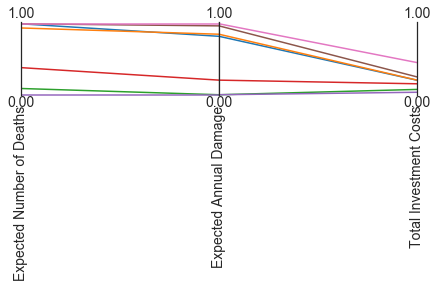

In [6]:
from ema_workbench.analysis import parcoords

data = results.loc[:, [o.name for o in robustness_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [8]:
#results

,A.1_DikeIncrease,A.2_DikeIncrease,A.3_DikeIncrease,A.4_DikeIncrease,A.5_DikeIncrease,0_RfR,1_RfR,2_RfR,3_RfR,4_RfR,EWS_DaysToThreat,Expected Number of Deaths,Expected Annual Damage,Total Investment Costs
0,7,8,10,7,9,0,0,0,0,0,3,0.971429,0.800000,0.198101
1,6,8,10,10,10,0,0,0,0,0,3,0.914286,0.828571,0.199490
2,0,0,5,5,9,0,0,0,0,0,3,0.085714,0.000000,0.072957
3,2,4,7,4,6,0,0,0,0,0,3,0.371429,0.200000,0.149928
4,0,0,6,4,0,0,0,0,0,0,3,0.000000,0.000000,0.034146
5,9,8,10,10,10,0,0,1,0,0,2,0.971429,0.942857,0.243573
6,6,10,9,9,9,1,0,1,1,0,1,0.971429,0.971429,0.439929


In [9]:
# putting a further a threshold to minimize the number of policues
results = results[results["Expected Number of Deaths"]>0.5]

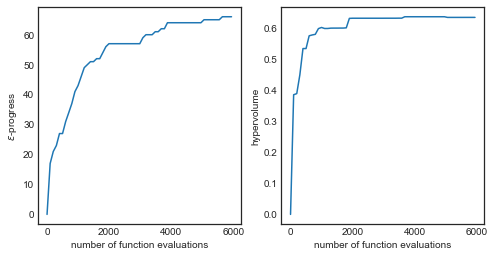

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [23]:
from ema_workbench import Policy

policies = results.drop([o.name for o in robustness_functions], axis=1)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy("moro {}".format(i), **policy.to_dict()))

AttributeError: 'tuple' object has no attribute 'drop'

# 4. Reevaluate Policies

In [27]:
n_scenarios = 1000
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [29]:
robustness_funcs = {'Total Investment Costs': total_investment_costs,
                    'Expected Number of Deaths': expected_number_of_deaths,
                    'Expected Annual Damage': expected_annual_damage}

import pandas as pd
experiments, outcomes = results

overall_robustness = {}
for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        values = values[logical]
        policy_robustness[outcome] = robustness_funcs[outcome](values)
    overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness = overall_robustness[overall_robustness["Expected Number of Deaths"]>0.5]
overall_robustness.to_csv(dike_model_MORO_6000nfe_35scenario
)

,Expected Annual Damage,Expected Number of Deaths,Total Investment Costs
moro 0,0.754,0.924,0.198101
moro 1,0.818,0.923,0.199490
moro 5,0.894,0.966,0.243573
moro 6,0.920,0.950,0.439929


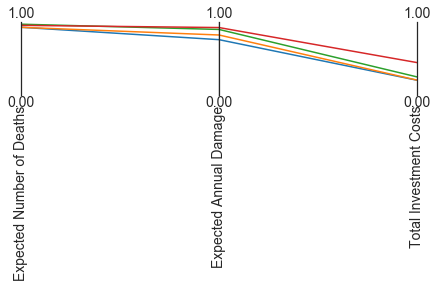

In [33]:
data = overall_robustness.loc[:, [o.name for o in robustness_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

## Utilizing Scenario Discovery for the Evaluation of the Policy Sets

In [35]:
from ema_workbench.analysis import prim
%matplotlib inline

experiments, outcomes = results
X = pd.DataFrame(experiments)
z = np.unique(X.policy)
z = np.delete(z,[0,1,5,6])

array(['moro 0', 'moro 1', 'moro 5', 'moro 6'], dtype=object)

[MainProcess/INFO] 1000 points remaining, containing 983 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.813, coverage: 0.82706002034588, density: 1.0 restricted_dimensions: 4


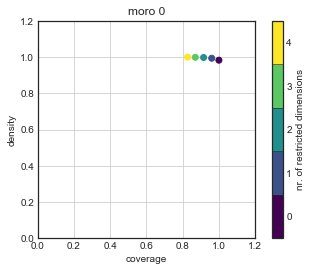

[MainProcess/INFO] 1000 points remaining, containing 971 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.856, coverage: 0.8815653964984552, density: 1.0 restricted_dimensions: 3


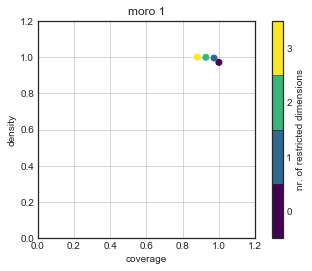

[MainProcess/INFO] 1000 points remaining, containing 995 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.856, coverage: 0.8603015075376884, density: 1.0 restricted_dimensions: 3


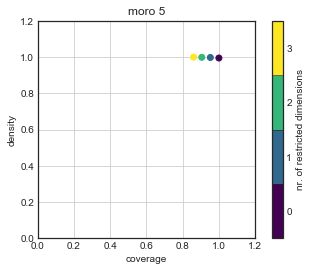

[MainProcess/INFO] 1000 points remaining, containing 984 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.813, coverage: 0.8262195121951219, density: 1.0 restricted_dimensions: 3


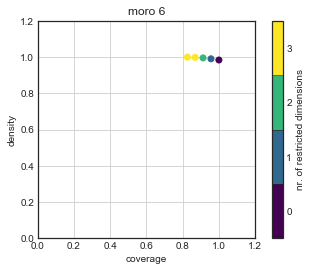

In [38]:
boxes = []
for i in range(len(z)):
    X = pd.DataFrame(experiments)
    X = X.iloc[:,:-1]
    y = pd.DataFrame(outcomes)
    policy = (X.policy == z[i])
    X = X[X['policy'] == z[i]]
    X = X.to_records()
    y = (y[policy]['Expected Number of Deaths'] < 0.005)
    y = y.reset_index(drop = True)
    prim_alg = prim.Prim(X, y, threshold=0.8, peel_alpha = 0.05)
    box = prim_alg.find_box()
    boxes.append(box)
    box.show_tradeoff()
    plt.grid()
    plt.title(z[i])
    plt.show()

[MainProcess/INFO] 1000 points remaining, containing 787 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.661, coverage: 0.8398983481575604, density: 1.0 restricted_dimensions: 5


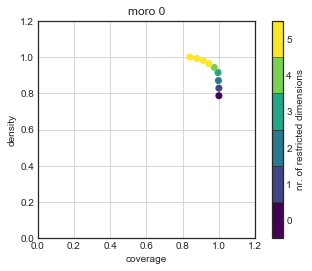

[MainProcess/INFO] 1000 points remaining, containing 842 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.696, coverage: 0.8266033254156769, density: 1.0 restricted_dimensions: 5


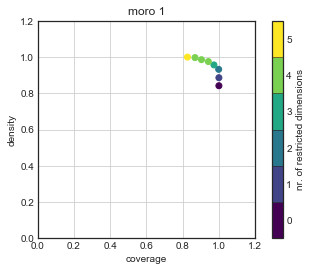

[MainProcess/INFO] 1000 points remaining, containing 915 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.772, coverage: 0.8437158469945355, density: 1.0 restricted_dimensions: 5


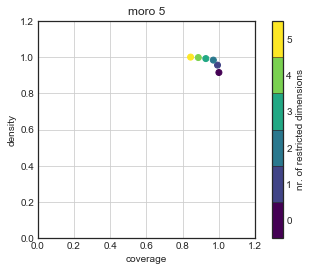

[MainProcess/INFO] 1000 points remaining, containing 933 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.772, coverage: 0.827438370846731, density: 1.0 restricted_dimensions: 5


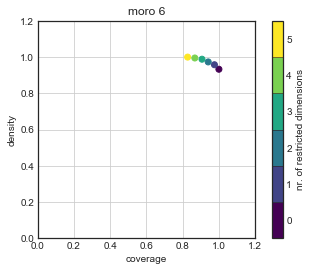

In [39]:
for i in range(len(z)):
    X = pd.DataFrame(experiments)
    X = X.iloc[:,:-1]
    y = pd.DataFrame(outcomes)
    policy = (X.policy == z[i])
    X = X[X['policy'] == z[i]]
    X = X.to_records()
    y = (y[policy]['Expected Annual Damage'] < 1e6)
    y = y.reset_index(drop = True)
    prim_alg = prim.Prim(X, y, threshold=0.8, peel_alpha = 0.05)
    box = prim_alg.find_box()
    boxes.append(box)
    box.show_tradeoff()
    plt.grid()
    plt.title(z[i])
    plt.show()

In [ ]:
box.inspect(i = 11, style = 'table')
box.inspect(i = 11, style = 'graph')

In [ ]:
box.select(11)
fig = box1.show_pairs_scatter()